# __Tutorial 2: Generation of stochastic DFN networks__

In most of the cases, a direct observation of the fractured volume is not possible, and fractures cannot be modelled deterministically. Hence, the modelling must be __stochastic__.
<br>
Stochastic Discrete Fracture Network models describe fractured rocks as a __population of individual fractures__, whose parameters (size, shape, orientation, aperture and position) are drawn from __statistical probability distributions derived from data__.

For 3D stochastic DFN models, we need to define statistical distributions for:
- Positions: uniform, fractal, bootstrapped
- Orientations: uniform, Fisher, bootstrapped
- Sizes: uniform, power-law, exponential, bootstrapped

We also need an ending criteria: fracture number, density, or percolation paramter 

In this tutorial, we will see how to use the __DFNGenerator__ module to generate stochastic Discrete Fracture Networks
<br>
We will need the __DFNGenerator__ and __DFNBasis__ modules
<br>
We need the __DFNIO__ module for visualization. 
<br>
For rendering into the Jupyter Notebook, we use [_pyvista_](https://docs.pyvista.org).

In [1]:
import dfnlab.DFNIO as dfn_io
import dfnlab.DFNBasis as dfn
import dfnlab.DFNGenerator as dfn_gen
import pyvista as pv
import numpy as np
import os 

In [2]:
display = True

## Example 1: Constant size network

We generate here a Discrete Fracture Network in a cubic system of size $L=100$ with:
- constant fracture size $l=10$
- uniform orientation distribution
- percolation parameter $p=5$

First we need to create an empty _DFN_ from a _System_

In [3]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 100.)
fnet = dfn.DFN(system)

Then we create a _PoissonGenerator_ object from this _DFN_, and set all the statistical distributions

In [4]:
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesUniform(10,10)
generator.setPositionsUniform()
generator.setOrientationsUniform()
generator.setStopPercolation(5)
generator.generate()
fnet.computeIntersections()

Then we visualize our network

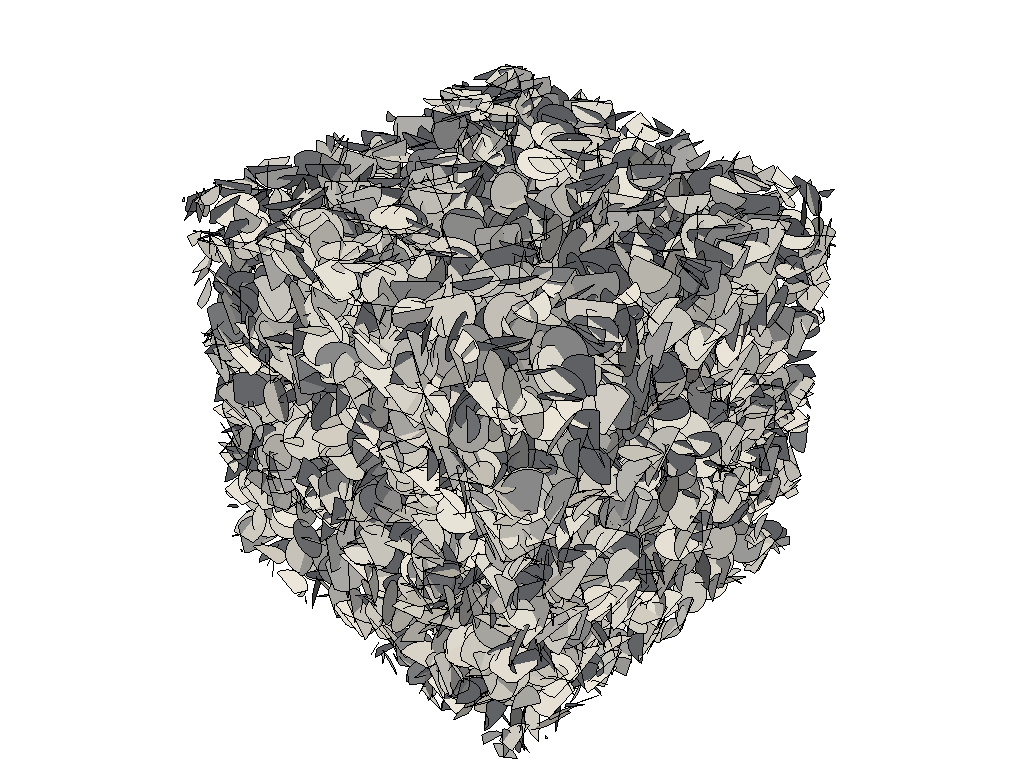

In [5]:
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    dfn_io.write_DFN_file(fnet,pathFolder+"/dfn.vtp")
    visu = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True)
    p.show(auto_close=False, use_panel=False)

## Example 2: Power-law size distribution

We generate here a Discrete Fracture Network in a cubic system of size $L=100$, following a power-law size distribution $n(l)=\alpha.l^{-a}$ so that: 
* Exponent $a=3$
* Minimum and maximum fracture sizes are $l_{min}=1$ and $l_{max}=100$
* Orientations are drawn from a Fisher distribution of parameters $dip=45$, $dipdir=90$, and a dispersion factor $\kappa=15$
* Fracture intensity $p_{32}=0.25$

In [6]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 100.)
fnet = dfn.DFN(system)

In [7]:
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,1,100)
generator.setPositionsUniform()
generator.setOrientationsFisher(45,90,15)
generator.setStopDensity(0.25)
generator.generate()
fnet.computeIntersections()

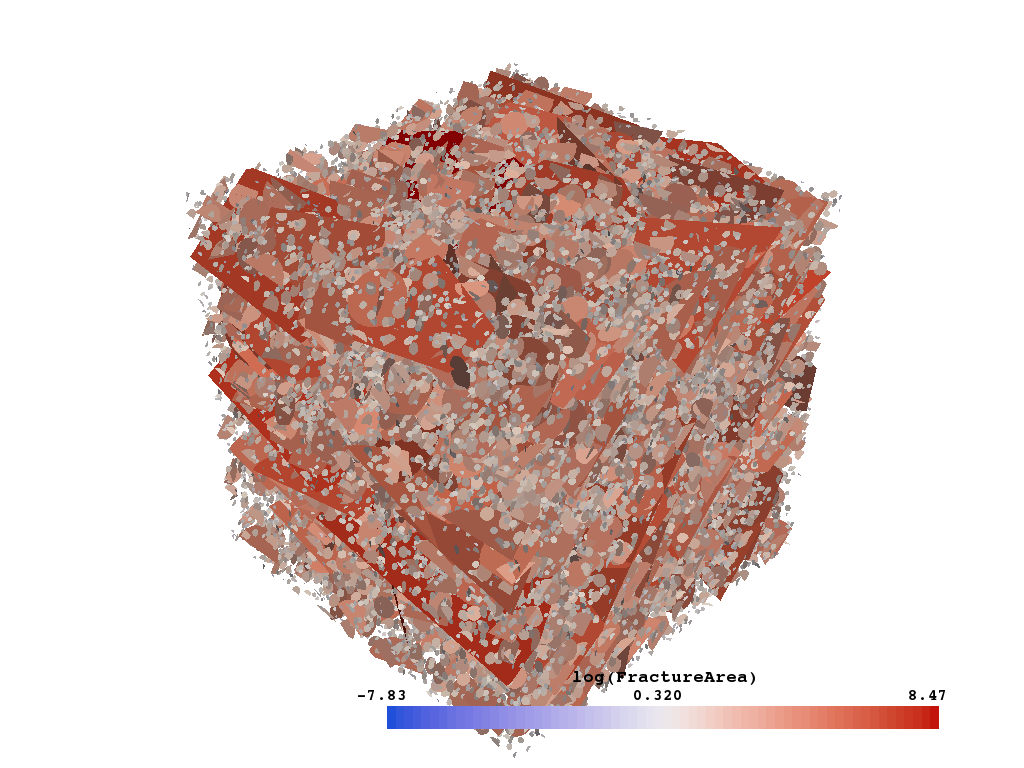

In [8]:
if display:
    dfn_io.write_DFN_file(fnet,pathFolder+"/dfn.vtp")
    visu = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    visu['log(FractureArea)'] = np.log(visu['FractureArea'])
    p.add_mesh(visu, scalars='log(FractureArea)', cmap='coolwarm',lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
    p.show(auto_close=False, use_panel=False)

## Example 3: Fractal positioning of fractures

We generate here a Discrete Fracture Network with fracture positions following a fractal distribution of given correlation dimension $D_2$. The number of iteration _nbIteration_ means that we cut the system size in $2^{nbIteration}$: the system itself is then divided into $2^{3^{nbIteration}}$ parts.

Fracture positions are then drawn from a fractal spatial density distribution, resulting from a multiplicative cascade process
[_[Darcel et al, 2003]_](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002WR001628).  The principle of the multiplicative cascade process is a recursive operation of fragmentation of the system in $n$ subdomains. Then a probability $P_i$, with $i = 1..n$, is attributed to each subdomain. The fragmentation cascade is then iterated; at each stage of the fragmentation process, a fragment takes one of the $P_i$ probabilities multiplied by the probability of the parent domain.



In [9]:
D2 = 2.7
nbIteration = 6

In [10]:
system = dfn.System()
system.buildParallelepiped([0, 0, 0], 100.)
fnet = dfn.DFN(system)

generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,2.,100)
generator.setPositionsFractal(D2,nbIteration)
generator.setOrientationsUniform()
generator.setStopNumber(10000)
generator.generate()
fnet.computeIntersections()

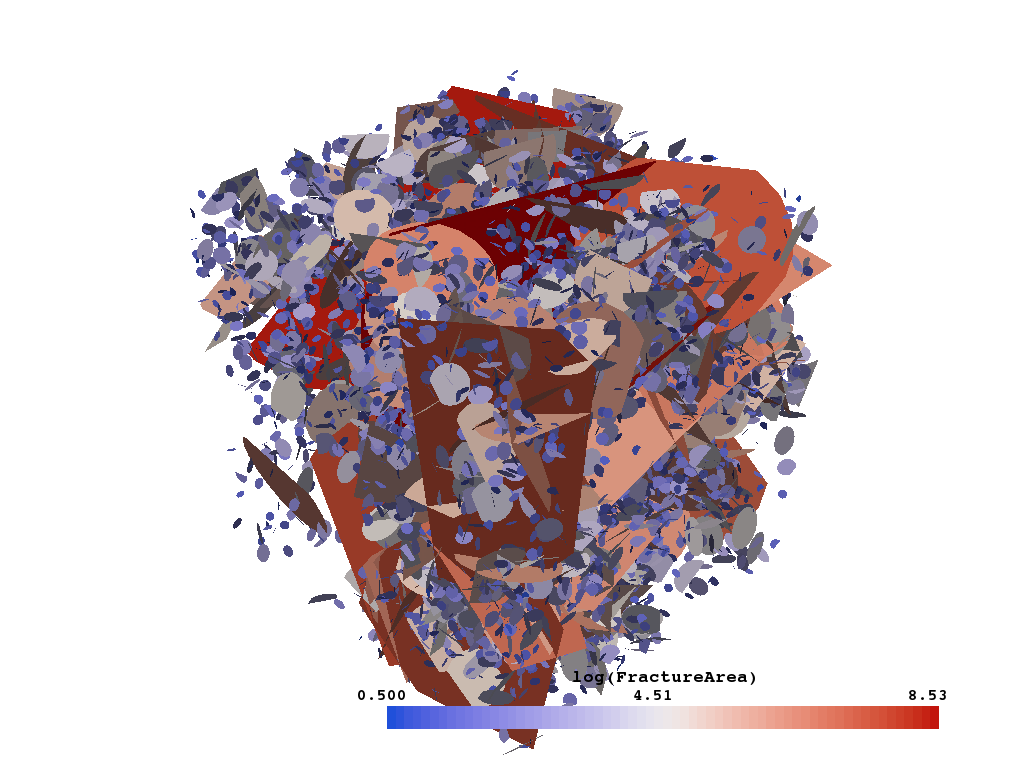

In [11]:
if display:
    dfn_io.write_DFN_file(fnet,pathFolder+"/dfn.vtp")
    visu = pv.read(pathFolder+"/dfn.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    visu['log(FractureArea)'] = np.log(visu['FractureArea'])
    p.add_mesh(visu, scalars='log(FractureArea)', cmap='coolwarm',lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
    p.show(auto_close=False, use_panel=False)

We now use the __DFNAnalysis__ module to check the correlation dimension associated to the generated _DFN_. In order to do so, we compute the _correlation pair function_ of fracture centers, and its derivative [_[Hentschel and Procaccia, 1983]_](https://www.sciencedirect.com/science/article/abs/pii/016727898390235X). This method computes the probability for two fractures to belong to the same cluster.

In [12]:
import dfnlab.DFNAnalysis as dfnA
analyser = dfnA.DFNAnalyser(fnet)
c2r = analyser.correlationPairFunction3D(rmin=1,nbin=20)

We plot here the the derivative of the correlation pair function, as a function of points pair distance $r$. This quantity is equal to the correlation dimension, except for small and large distances, because of finite size effects.

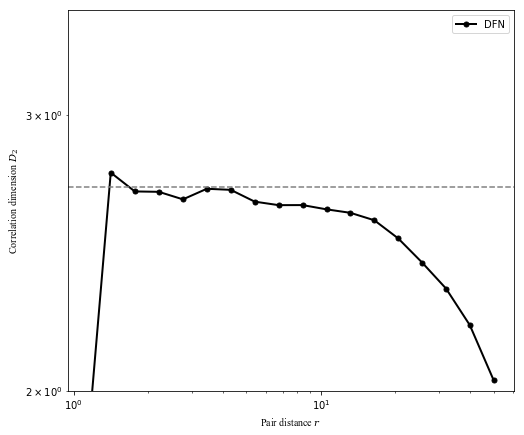

In [14]:
import matplotlib.pyplot as pyplot 

# prepare plot
csfont = {'fontname':'Times New Roman'}
pyplot.rcParams['mathtext.fontset'] = 'dejavuserif'
fig = pyplot.figure(figsize=(8, 7))
ax = pyplot.axes()
ax.set_xscale("log")
ax.set_yscale("log")

# get 
r = np.array(c2r['r_mean'])
idx1 = [True if r[i]!=0 else False for i in range(0,len(r)) ]
Dc = np.array(c2r['correlation_dimention'])
idx2 = [True if Dc[i]!=0 else False for i in range(0,len(Dc)) ]
idx = idx1 and idx2
r = r[idx]
Dc = Dc[idx]
ax.plot(r,Dc,marker='o',markersize=5, linewidth=2, color='k',label='DFN')
ax.set_ylim(2,3.5)
ax.axhline(D2,linestyle = 'dashed', color = 'grey')

pyplot.xlabel('Pair distance $r$',**csfont)
pyplot.ylabel('Correlation dimension $D_2$',**csfont)
pyplot.legend()
pyplot.show()